# Deep learning model validation 

This notebook can be used to validate a deep learning model. At the top the data and model can be loaded into memory, and in the following cells functions for validation can be found.

In [1]:
import sys, os, fnmatch, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.dirname(os.getcwd()))

from config import PATH_RAW_DATA, PATH_DATA_PROCESSED_DL, PATH_MODELS

# 1. Preparing data, model, and helper functions

## Configuration variables

In [2]:
N_AVERAGE = 30
MODEL_NAME = 'Fully_connected_regressor_02.hdf5'

## Load data

In [3]:
from sklearn.model_selection import train_test_split

# Step 1: Get all the files in the output folder
file_names = os.listdir(PATH_DATA_PROCESSED_DL)

# Step 2: Get the full paths of the files (without extensions)
files = [os.path.splitext(os.path.join(PATH_DATA_PROCESSED_DL, file_name))[0] for file_name in fnmatch.filter(file_names, "*.zarr")]

# Step 3: Load all the metadata
frames = []

for idx, feature_file in enumerate(files):
    df_metadata = pd.read_csv(feature_file.replace("processed_raw_", "processed_metadata_") + ".csv")
    frames.append(df_metadata)

df_metadata = pd.concat(frames) 

# Step 4: Add missing age information based on the age group the subject is in
df_metadata['age_months'].fillna(df_metadata['age_group'], inplace=True)
df_metadata['age_days'].fillna(df_metadata['age_group']*30, inplace=True)
df_metadata['age_years'].fillna(df_metadata['age_group']/12, inplace=True)

# Step 5: List all the unique subject IDs
subject_ids = list(set(df_metadata["code"].tolist()))

In [4]:
from sklearn.model_selection import train_test_split

IDs_train, IDs_temp = train_test_split(subject_ids, test_size=0.3, random_state=42)
IDs_test, IDs_val = train_test_split(IDs_temp, test_size=0.5, random_state=42)

In [5]:
from dataset_generator import DataGenerator

train_generator = DataGenerator(list_IDs = IDs_train,
                                BASE_PATH = PATH_DATA_PROCESSED_DL,
                                metadata = df_metadata,
                                n_average = N_AVERAGE,
                                batch_size = 10,
                                iter_per_epoch = 30,
                                n_timepoints = 501, 
                                n_channels=30, 
                                shuffle=True)

train_generator_noise = DataGenerator(list_IDs = IDs_train,
                                      BASE_PATH = PATH_DATA_PROCESSED_DL,
                                      metadata = df_metadata,
                                      n_average = N_AVERAGE,
                                      batch_size = 10,
                                      gaussian_noise=0.01,
                                      iter_per_epoch = 30,
                                      n_timepoints = 501, 
                                      n_channels=30, 
                                      shuffle=True)

val_generator = DataGenerator(list_IDs = IDs_val,
                              BASE_PATH = PATH_DATA_PROCESSED_DL,
                              metadata = df_metadata,
                              n_average = N_AVERAGE,
                              batch_size = 10,
                              iter_per_epoch = 100,
                              n_timepoints = 501,
                              n_channels=30,
                              shuffle=True)

test_generator = DataGenerator(list_IDs = IDs_test,
                               BASE_PATH = PATH_DATA_PROCESSED_DL,
                               metadata = df_metadata,
                               n_average = N_AVERAGE,
                               batch_size = 10,
                               iter_per_epoch = 100,
                               n_timepoints = 501,
                               n_channels=30,
                               shuffle=True)

In [6]:
df_metadata.head()

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years
0,23,/Volumes/Seagate Expansion Drive/ePodium/Data/...,023_35_mc_mmn36,35,1052.0,35.066667,2.922222
0,337,/Volumes/Seagate Expansion Drive/ePodium/Data/...,337_23_jc_mmn_36_wk,23,692.0,23.066667,1.922222
0,456,/Volumes/Seagate Expansion Drive/ePodium/Data/...,456_23_md_mmn36_wk,23,691.0,23.033333,1.919444
0,328,/Volumes/Seagate Expansion Drive/ePodium/Data/...,328_23_jc_mmn36_wk,23,699.0,23.300000,1.941667
0,314,/Volumes/Seagate Expansion Drive/ePodium/Data/...,314_29_mmn_36_wk,29,877.0,29.233333,2.436111


## Load model

In [7]:
import tensorflow as tf

model_path = os.path.join(PATH_MODELS, MODEL_NAME)
loaded_model = tf.keras.models.load_model(model_path)

## Testing phase helper functions: three approaches

### 1. Predict age for all epochs separately, take median

In [9]:
from scipy import stats

def test_model_separate_epochs(model, ID_test):
    """Takes in the IDs of the test subjects, predicts the ages on individual epochs per subject per age group. 
        Final prediction for the subject in an age group is the median of all predictions."""
    
    y_true = []
    y_pred = []
    pred_IDs = []
    
    # Step 1: Iterate over subjects
    for ID in IDs_test:
        
        # Step 2: Find all files of a subject
        df_temp = df_metadata[df_metadata['code'] == ID]
    
        # Step 3: Find all the age groups the subject was found in
        ages_subject = sorted(list(set(df_temp['age_group'].tolist())))
        
        # Step 4: Loop over all the age groups the subject is in
        for age_group in ages_subject:            
            X_data = np.zeros((0, 30, 501))
            
            # Step 5: Concatenate data of files in the same age group
            for i, metadata_file in df_temp[df_temp['age_group'] == age_group].iterrows():
                filename = os.path.join(PATH_DATA_PROCESSED_DL, 'processed_raw_' + metadata_file['cnt_file'] + '.zarr')
                data_signal = zarr.open(os.path.join(filename), mode='r')
                                
                X_data = np.concatenate((X_data, data_signal), axis=0)
                
            X_data = np.swapaxes(X_data, 1, 2)
                                
            # Step 6: Predict age of all the epochs, take median
            predicted_ages = model.predict(X_data).flatten()
            
            predicted_age = np.median(predicted_ages)
            true_age = df_temp[df_temp['age_group'] == age_group]['age_months'].values[0]
            
            y_pred.append(predicted_age)
            y_true.append(true_age)
            pred_IDs.append(ID)

    return y_true, y_pred, pred_IDs

### 2. Divide all epochs in non-overlapping subsets, average and predict, take median

In [10]:
def chunks(lst, n):
    """Yield successive n-sized chunks from list."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def test_model_epochs_subsets(model, ID_test):
    """Takes in the IDs of the test subjects, divides all epochs in subsets of 30 and averages. 
        Final prediction for the subject is the median of all predictions on these subsets."""
    
    y_true = []
    y_pred = []
    pred_IDs = []
    
    # Step 1: Iterate over subjects
    for ID in IDs_test:
        
        # Step 2: Find all files of a subject
        df_temp = df_metadata[df_metadata['code'] == ID]
    
        # Step 3: Find all the age groups the subject was found in
        ages_subject = sorted(list(set(df_temp['age_group'].tolist())))
        
        # Step 4: Loop over all the age groups the subject is in
        for age_group in ages_subject:            
            X_data = np.zeros((0, 30, 501))
            X_averaged_subsets = np.zeros((0, 30, 501))
            
            # Step 5: Concatenate data of files in the same age group
            for i, metadata_file in df_temp[df_temp['age_group'] == age_group].iterrows():
                filename = os.path.join(PATH_DATA_PROCESSED_DL, 'processed_raw_' + metadata_file['cnt_file'] + '.zarr')
                data_signal = zarr.open(os.path.join(filename), mode='r')
                                
                X_data = np.concatenate((X_data, data_signal), axis=0)
            
            np.random.shuffle(X_data) # Shuffle data for randomly picking epochs without replacement
            
            for subset in chunks(X_data, 30):
                X_data_mean = np.mean(subset[:,:,:], axis=0) # Average all epochs in subset
                X_data_mean = np.expand_dims(X_data_mean, axis=0)
                X_averaged_subsets = np.concatenate((X_averaged_subsets, X_data_mean), axis=0)
            
            X = np.swapaxes(X_averaged_subsets, 1, 2)
                                            
            # Step 6: Predict age of the averaged epochs
            predicted_ages = model.predict(X).flatten()
            predicted_age = np.median(predicted_ages)
            
            true_age = df_temp[df_temp['age_group'] == age_group]['age_months'].values[0]
            
            y_pred.append(predicted_age)
            y_true.append(true_age)
            pred_IDs.append(ID)

    return y_true, y_pred, pred_IDs

### 3. Average all epochs and predict

In [11]:
def test_model_averaged_epochs(model, ID_test):
    """Takes in the IDs of the test subjects, averages epochs per subject per age group. 
        Final prediction for the subject in an age group is on this averaged epoch."""
    
    y_true = []
    y_pred = []
    pred_IDs = []
    
    # Step 1: Iterate over subjects
    for ID in IDs_test:
        
        # Step 2: Find all files of a subject
        df_temp = df_metadata[df_metadata['code'] == ID]
    
        # Step 3: Find all the age groups the subject was found in
        ages_subject = sorted(list(set(df_temp['age_group'].tolist())))
        
        # Step 4: Loop over all the age groups the subject is in
        for age_group in ages_subject:            
            X_data = np.zeros((0, 30, 501))
            
            # Step 5: Concatenate data of files in the same age group
            for i, metadata_file in df_temp[df_temp['age_group'] == age_group].iterrows():
                filename = os.path.join(PATH_DATA_PROCESSED_DL, 'processed_raw_' + metadata_file['cnt_file'] + '.zarr')
                data_signal = zarr.open(os.path.join(filename), mode='r')
                                
                X_data = np.concatenate((X_data, data_signal), axis=0)
            
            X_data_mean = np.mean(X_data[:,:,:], axis=0) # Average all epochs of a subject at a specific age
            X = np.expand_dims(X_data_mean, axis=0)            
            X = np.swapaxes(X, 1, 2)
                                            
            # Step 6: Predict age of the averaged epochs
            predicted_age = model.predict(X).flatten()[0]
            true_age = df_temp[df_temp['age_group'] == age_group]['age_months'].values[0]
            
            y_pred.append(predicted_age)
            y_true.append(true_age)
            pred_IDs.append(ID)

    return y_true, y_pred, pred_IDs

## Error stability: two approaches

Definition of error stability (Vandenbosch et al., 2018): 

_"Stability was assessed as the correlation between the prediction errors (estimated minus actual age) of subjects at baseline with their own prediction error at follow-up."_


I think this means: Take the prediction error (of a subject) at time 1 and compare it to the prediction error at time 2, take the prediction error at time 2 and compare it to time 3, take the prediction error at time 3 and compare it to time 4. You can then make two lists of errors: TIME_N and TIME_N+1 and look at the correlation between those two. 

A stable error then would mean a positive correlation, because if error is low at time n, you expect it to be low at time n+1 as well. 

### 1. Average all epochs and predict, calculate stability

In [17]:
import zarr
from scipy.stats import pearsonr

def error_stability_averaged_epochs(model, IDs_test):
    """Takes in the IDs of the test subjects, calculates the error stability (correlation) on average of all epochs"""
    
    errors_time_N = []
    errors_time_N1 = []
    
    # Step 1: Iterate over subjects
    for ID in IDs_test:
        
        # Step 2: Find all files of a subject
        df_temp = df_metadata[df_metadata['code'] == ID]
    
        # Step 3: Find all the age groups the subject was found in
        ages_subject = sorted(list(set(df_temp['age_group'].tolist())))
        
        if len(ages_subject) == 1:
            continue
                    
        # Step 4: Loop over all the ages of a subject
        prev_prediction_error = None
        curr_prediction_error = None
                       
        for age_group in ages_subject:
            prev_prediction_error = curr_prediction_error
            
            X_data = np.zeros((0, 30, 501))
            
            # Step 5: Concatenate data of files in the same age group before averaging all epochs
            for i, metadata_file in df_temp[df_temp['age_group'] == age_group].iterrows():
                filename = os.path.join(PATH_DATA_PROCESSED_DL, 'processed_raw_' + metadata_file['cnt_file'] + '.zarr')
                data_signal = zarr.open(os.path.join(filename), mode='r')
                                
                X_data = np.concatenate((X_data, data_signal), axis=0) 
            
            X_data_mean = np.mean(X_data[:,:,:], axis=0) # Average all epochs of a subject at a specific age
            X = np.expand_dims(X_data_mean, axis=0)            
            X = np.swapaxes(X, 1, 2)
                                    
            actual_age = df_temp[df_temp['age_group'] == age_group]['age_months'].values[0]
            curr_prediction_error = model.predict(X).flatten()[0] - actual_age
                        
            # Step 6: If there are two values to compare, i.e. time N and time N+1, add them to the lists
            if prev_prediction_error and curr_prediction_error:
                
                errors_time_N.append(prev_prediction_error)
                errors_time_N1.append(curr_prediction_error)
                
    # Step 7: Look at correlation between prediction error and follow-up
    corr, _ = pearsonr(errors_time_N, errors_time_N1)
    print(f"Pearsons correlation: {corr:.3f}")
    
    return corr, errors_time_N, errors_time_N1

### 2.  Divide all epochs in non-overlapping subsets, average and predict, take median, calculate stability

In [18]:
import zarr
from scipy.stats import pearsonr, spearmanr

def chunks(lst, n):
    """Yield successive n-sized chunks from list."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def error_stability_epochs_subsets(model, ID_test):
    """Takes in the IDs of the test subjects, divides all epochs in subsets of 30 and averages. 
        Final prediction for the subject is the median of all predictions on these subsets. 
        Error stability is calculated based on these predictions. """
    
    errors_time_N = []
    errors_time_N1 = []
    
    # Step 1: Iterate over subjects
    for ID in IDs_test:
        
        # Step 2: Find all files of a subject
        df_temp = df_metadata[df_metadata['code'] == ID]
    
        # Step 3: Find all the age groups the subject was found in
        ages_subject = sorted(list(set(df_temp['age_group'].tolist())))
        
        if len(ages_subject) == 1:
            continue
        
        prev_prediction_error = None
        curr_prediction_error = None
        
        # Step 4: Loop over all the age groups the subject is in
        for age_group in ages_subject:
            
            prev_prediction_error = curr_prediction_error
            
            X_data = np.zeros((0, 30, 501))
            X_averaged_subsets = np.zeros((0, 30, 501))
            
            # Step 5: Concatenate data of files in the same age group
            for i, metadata_file in df_temp[df_temp['age_group'] == age_group].iterrows():
                filename = os.path.join(PATH_DATA_PROCESSED_DL, 'processed_raw_' + metadata_file['cnt_file'] + '.zarr')
                data_signal = zarr.open(os.path.join(filename), mode='r')
                                
                X_data = np.concatenate((X_data, data_signal), axis=0)
            
            np.random.shuffle(X_data) # Shuffle data for randomly picking epochs without replacement
            
            for subset in chunks(X_data, 30):
                X_data_mean = np.mean(subset[:,:,:], axis=0) # Average all epochs in subset
                X_data_mean = np.expand_dims(X_data_mean, axis=0)
                X_averaged_subsets = np.concatenate((X_averaged_subsets, X_data_mean), axis=0)
            
            X = np.swapaxes(X_averaged_subsets, 1, 2)
                                            
            # Step 6: Predict age of the averaged epochs
            predicted_ages = model.predict(X).flatten()
            predicted_age = np.median(predicted_ages)
            
            actual_age = df_temp[df_temp['age_group'] == age_group]['age_months'].values[0]
            curr_prediction_error = predicted_age - actual_age
                        
            # Step 7: If there are two values to compare, i.e. time N and time N+1, add them to the lists
            if prev_prediction_error and curr_prediction_error:
                errors_time_N.append(prev_prediction_error)
                errors_time_N1.append(curr_prediction_error)     
        
    # Step 8: Look at correlation between prediction error and follow-up
    corr, _ = pearsonr(errors_time_N, errors_time_N1)
    spearmancorr, _ = spearmanr(errors_time_N, errors_time_N1)
    print(f"Pearsons correlation: {corr:.3f}")
    print(f"Spearman correlation: {spearmancorr:.3f}")
    
    return corr, spearmancorr, errors_time_N, errors_time_N1

# 2. Model validation

In [19]:
# from sklearn.metrics import mean_absolute_error

# y_true, y_pred = test_model_separate_epochs(loaded_model, IDs_test)
# mean_absolute_error(y_true, y_pred)

In [23]:
from sklearn.metrics import mean_absolute_error

y_true, y_pred, pred_IDs = test_model_epochs_subsets(loaded_model, IDs_test)
mean_absolute_error(y_true, y_pred)

5.715488900186244

In [20]:
# from sklearn.metrics import mean_absolute_error

# y_true, y_pred = test_model_averaged_epochs(loaded_model, IDs_test)
# mean_absolute_error(y_true, y_pred)

In [21]:
corr, spearmancorr, errors_time_N, errors_time_N1 = error_stability_epochs_subsets(loaded_model, IDs_test)

Pearsons correlation: 0.660


In [ ]:
from sklearn.metrics import r2_score

rsquared = r2_score(y_true, y_pred)
print(f"R-squared: {rsquared:.3f}")

In [22]:
# error_stability_averaged_epochs(loaded_model, IDs_test)

# 3. Visualization

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

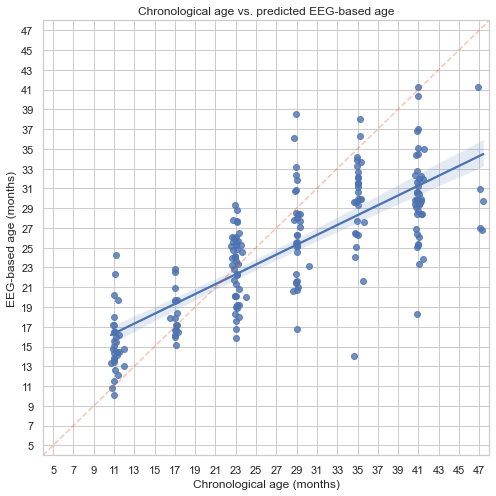

In [48]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=y_true, y=y_pred)

ax.set_xlim(4, 48)
ax.set_ylim(4, 48)

ax.set_xticks(np.arange(5, 48, 2.0))
ax.set_yticks(np.arange(5, 48, 2.0))

ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=(1,0.2,0,0.3))
ax.grid()
ax.set_axisbelow(True)

ax.set_xlabel('Chronological age (months)')
ax.set_ylabel('EEG-based age (months)')
ax.set_title('Chronological age vs. predicted EEG-based age')

plt.grid()

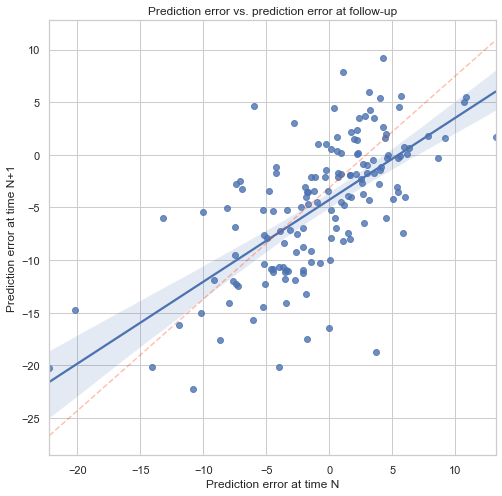

In [49]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=errors_time_N, y=errors_time_N1)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=(1,0.2,0,0.3))
ax.grid()
ax.set_axisbelow(True)

ax.set_xlabel('Prediction error at time N')
ax.set_ylabel('Prediction error at time N+1')
ax.set_title('Prediction error vs. prediction error at follow-up')

plt.grid()

# 4. Model certainty / Monte Carlo Dropout

In [83]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense, Conv1D, LeakyReLU, AveragePooling1D, Flatten, Reshape, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

n_timesteps = 501
n_features = 30 
n_outputs = 1

input_shape = (n_timesteps, n_features)

def fully_connected_model():
    """ Returns the fully connected model from Ismail Fawaz et al. (2019). """

    input_layer = keras.layers.Input(input_shape)

    input_layer_flattened = keras.layers.Flatten()(input_layer)

    layer_1 = keras.layers.Dropout(0.1)(input_layer_flattened, training=True)
    layer_1 = keras.layers.Dense(500, activation='relu')(layer_1)

    layer_2 = keras.layers.Dropout(0.2)(layer_1, training=True)
    layer_2 = keras.layers.Dense(500, activation='relu')(layer_2)

    layer_3 = keras.layers.Dropout(0.2)(layer_2, training=True)
    layer_3 = keras.layers.Dense(500, activation='relu')(layer_3)

    output_layer = keras.layers.Dropout(0.3)(layer_3, training=True)
    output_layer = keras.layers.Dense(1)(output_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

In [89]:
from scipy.stats import bayes_mvs

def chunks(lst, n):
    """Yield successive n-sized chunks from list."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def test_model_epochs_subsets(model, ID_test):
    """Takes in the IDs of the test subjects, divides all epochs in subsets of 30 and averages. 
        Final prediction for the subject is the median of all predictions on these subsets."""
        
    y_true = []
    y_pred = []
    
    # Step 1: Iterate over subjects
    for ID in IDs_test:
        
        # Step 2: Find all files of a subject
        df_temp = df_metadata[df_metadata['code'] == ID]
    
        # Step 3: Find all the age groups the subject was found in
        ages_subject = sorted(list(set(df_temp['age_group'].tolist())))
        
        # Step 4: Loop over all the age groups the subject is in
        for age_group in ages_subject:            
            X_data = np.zeros((0, 30, 501))
            X_averaged_subsets = np.zeros((0, 30, 501))
            
            # Step 5: Concatenate data of files in the same age group
            for i, metadata_file in df_temp[df_temp['age_group'] == age_group].iterrows():
                filename = os.path.join(PATH_DATA_PROCESSED_DL, 'processed_raw_' + metadata_file['cnt_file'] + '.zarr')
                data_signal = zarr.open(os.path.join(filename), mode='r')
                                
                X_data = np.concatenate((X_data, data_signal), axis=0)
            
            np.random.shuffle(X_data) # Shuffle data for randomly picking epochs without replacement
            
            for subset in chunks(X_data, 30):
                X_data_mean = np.mean(subset[:,:,:], axis=0) # Average all epochs in subset
                X_data_mean = np.expand_dims(X_data_mean, axis=0)
                X_averaged_subsets = np.concatenate((X_averaged_subsets, X_data_mean), axis=0)
            
            X = np.swapaxes(X_averaged_subsets, 1, 2)
                                            
            # Monte Carlo Dropout: 
            
            predicted_ages_MCdropout = []
            
            for i in range(50):                
                # Step 6: Predict age of the averaged epochs
                predicted_ages = model.predict(X).flatten()
                predicted_age = np.median(predicted_ages)
                predicted_ages_MCdropout.append(predicted_age)
            
#             print(predicted_ages_MCdropout)
#             res_mean, res_var, res_std = bayes_mvs(predicted_ages_MCdropout, alpha=0.95)
#             print(f"MEAN (predicted age): {res_mean.statistic}")
            
            true_age = df_temp[df_temp['age_group'] == age_group]['age_months'].values[0]
            
            y_pred.append(np.mean(predicted_ages_MCdropout))
#             y_pred.append(res_mean.statistic)
            y_true.append(true_age)

    return y_true, y_pred

In [90]:
from sklearn.metrics import mean_absolute_error

model_b = fully_connected_model()
model_b.load_weights(os.path.join(PATH_MODELS, MODEL_NAME))

y_true, y_pred = test_model_epochs_subsets(model_b, IDs_test)
mean_absolute_error(y_true, y_pred)

5.474997943226254